<a id='home'></a>
### Contents

[Imports](#Imports)

[Problem 11](#Problem11)

[Problem 12](#Problem12)

[Problem 14](#Problem14)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
!pip3 install -q optuna==3.0.2

     |████████████████████████████████| 348 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 8.7 MB/s  eta 0:00:01
     |████████████████████████████████| 209 kB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 58.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 69.7 MB/s eta 0:00:01


In [4]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [69]:
# to display decision tree
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [5]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [4]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


---

<a id='Problem11'></a>
### Problem 11
[back to contents](#home)

Обучить решающее дерево на [cholesterol_prediction.csv](https://drive.google.com/file/d/1vhcrknQ5oSRizxQK4fS_PxOeS11Fql6Q/view?usp=sharing). В качестве
целевой переменной рассмотрите "cardio".

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Data/cholesterol_prediction.csv', sep=';')
data.drop(['id'], axis=1, inplace=True)
print(f"{data.shape[0]:,} x {data.shape[1]:,}")
data.head()

70,000 x 12


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

X_tr, X_te = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
y_tr = X_tr['cardio']
del X_tr['cardio']

y_te = X_te['cardio']
del X_te['cardio']

print(f"y_tr: {y_tr.shape[0]:,}")
print(f"\t0: {sum(y_tr == 0):,} ({round(sum(y_tr == 0)*100/len(y_tr), 2)}%)")
print(f"\t1: {sum(y_tr == 1):,} ({round(sum(y_tr == 1)*100/len(y_tr), 2)}%)")
print()
print(f"y_te: {y_te.shape[0]:,}")
print(f"\t0: {sum(y_te == 0):,} ({round(sum(y_te == 0)*100/len(y_te), 2)}%)")
print(f"\t1: {sum(y_te == 1):,} ({round(sum(y_te == 1)*100/len(y_te), 2)}%)")

y_tr: 49,000
	0: 24,560 (50.12%)
	1: 24,440 (49.88%)

y_te: 21,000
	0: 10,461 (49.81%)
	1: 10,539 (50.19%)


In [41]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=None)
model.fit(X_tr, y_tr)

DecisionTreeClassifier()

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
train_acc = accuracy_score(
    y_true=y_tr,
    y_pred=model.predict(X_tr)
)
test_acc = accuracy_score(
    y_true=y_te,
    y_pred=model.predict(X_te)
)
print(f"train accuracy: {round(train_acc, 3)}")
print(f"test accuracy: {round(test_acc, 3)}") #overfitting

train accuracy: 1.0
test accuracy: 0.637


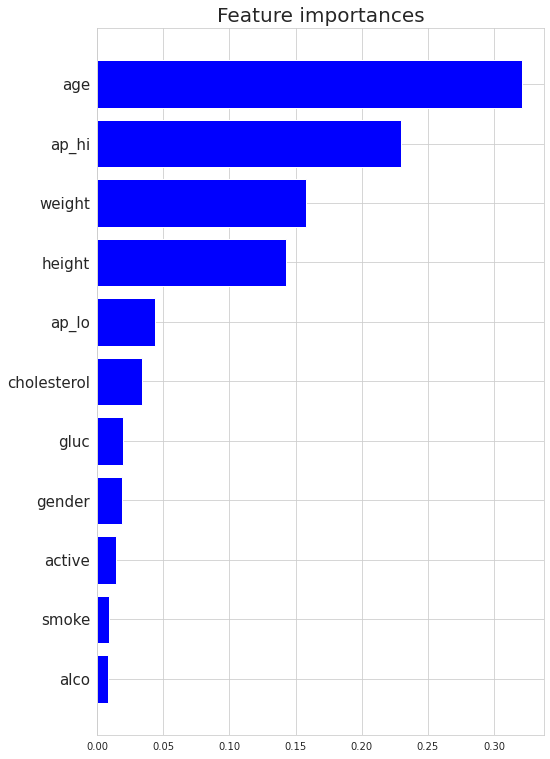

In [44]:
fn, fi = (
    model.feature_names_in_,
    model.feature_importances_
)
fn = np.array(fn)[np.argsort(fi)][::-1]
fi = np.sort(fi)[::-1]

plt.figure(figsize=(8, 13))
plt.title(f'Feature importances', fontsize=20);
plt.barh(fn[::-1], fi[::-1], color='blue');
plt.tick_params(axis='y', labelsize=15);

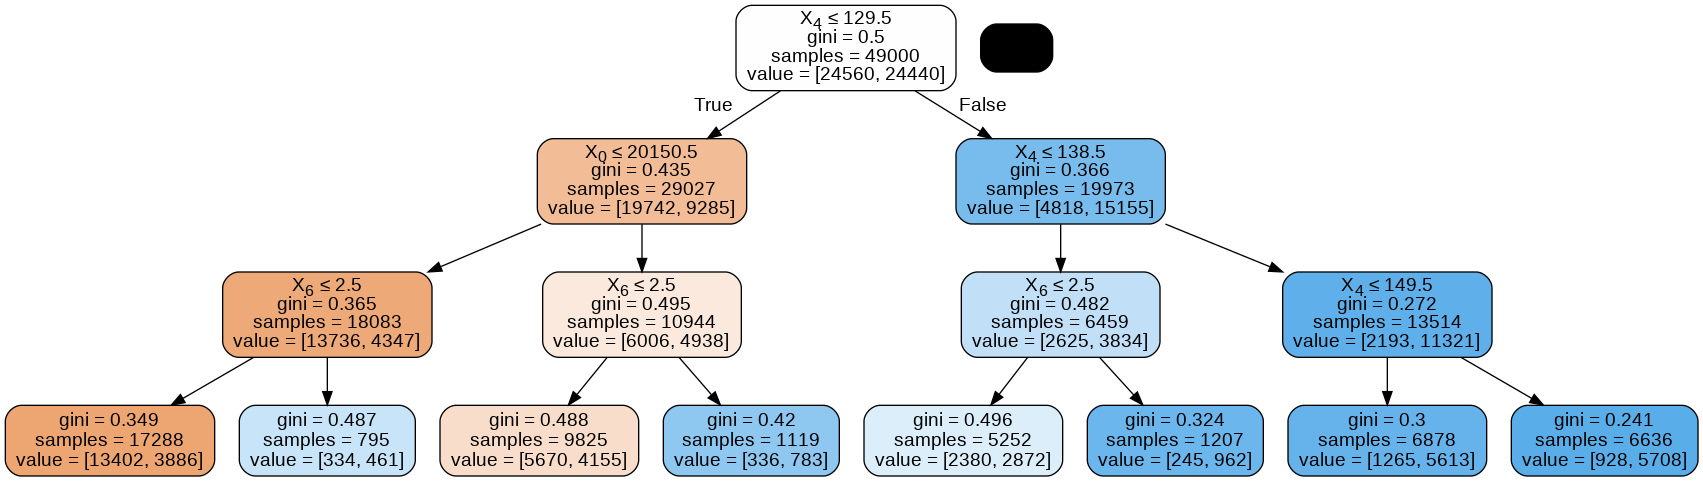

In [40]:
# only do in case of not deep tree!
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [17]:
import optuna
from optuna import trial
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

In [52]:
def objective(trial):
    params = {
        "criterion": trial.suggest_categorical('criterion', ['gini', 'entropy']),
        "splitter": "best",
        "max_depth": trial.suggest_int("max_depth", 1, 56),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 200),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 500),
        "max_features": None,
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5, 20_000, log=True),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0, 20)
    }
    model = DecisionTreeClassifier(**params)
        
    score = cross_val_score(
        estimator=model,
        X=X_tr,
        y=y_tr,
        scoring='accuracy',
        cv=KFold(n_splits=5, shuffle=True),
        n_jobs=-1,
        verbose=0
    )
    accuracy = np.mean(score)
    return accuracy

In [60]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
clear_output()
best_params = study.best_params
print("best trial:")
print(study.best_trial, end='\n'*2)
print("best params:")
print(best_params, end='\n'*2)

best trial:
FrozenTrial(number=89, values=[0.7298163265306122], datetime_start=datetime.datetime(2022, 9, 19, 10, 42, 39, 186288), datetime_complete=datetime.datetime(2022, 9, 19, 10, 42, 39, 797488), params={'criterion': 'entropy', 'max_depth': 31, 'min_samples_split': 178, 'min_samples_leaf': 246, 'max_leaf_nodes': 327, 'min_impurity_decrease': 0.00015175219257417688}, distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_depth': IntDistribution(high=56, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=200, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=500, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=20000, log=True, low=5, step=1), 'min_impurity_decrease': FloatDistribution(high=20.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=89, state=TrialState.COMPLETE, value=None)

best params:
{'criterion': 'entropy', 'max_depth': 31, 'min_samp

In [61]:
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_tr, y_tr)

DecisionTreeClassifier(criterion='entropy', max_depth=31, max_leaf_nodes=327,
                       min_impurity_decrease=0.00015175219257417688,
                       min_samples_leaf=246, min_samples_split=178)

In [63]:
train_acc = accuracy_score(
    y_true=y_tr,
    y_pred=best_model.predict(X_tr)
)
test_acc = accuracy_score(
    y_true=y_te,
    y_pred=best_model.predict(X_te)
)
print(f"train accuracy: {round(train_acc, 3)}")
print(f"test accuracy: {round(test_acc, 3)}") #overfitting

train accuracy: 0.732
test accuracy: 0.734


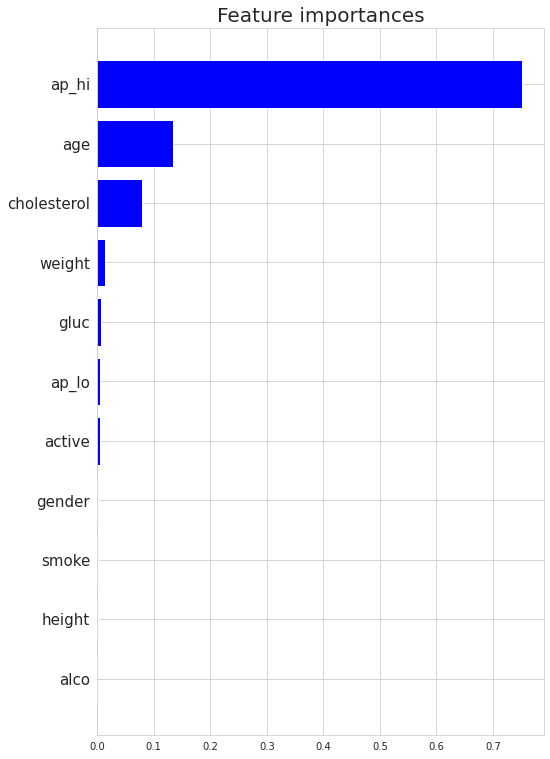

In [64]:
fn, fi = (
    best_model.feature_names_in_,
    best_model.feature_importances_
)
fn = np.array(fn)[np.argsort(fi)][::-1]
fi = np.sort(fi)[::-1]

plt.figure(figsize=(8, 13))
plt.title(f'Feature importances', fontsize=20);
plt.barh(fn[::-1], fi[::-1], color='blue');
plt.tick_params(axis='y', labelsize=15);

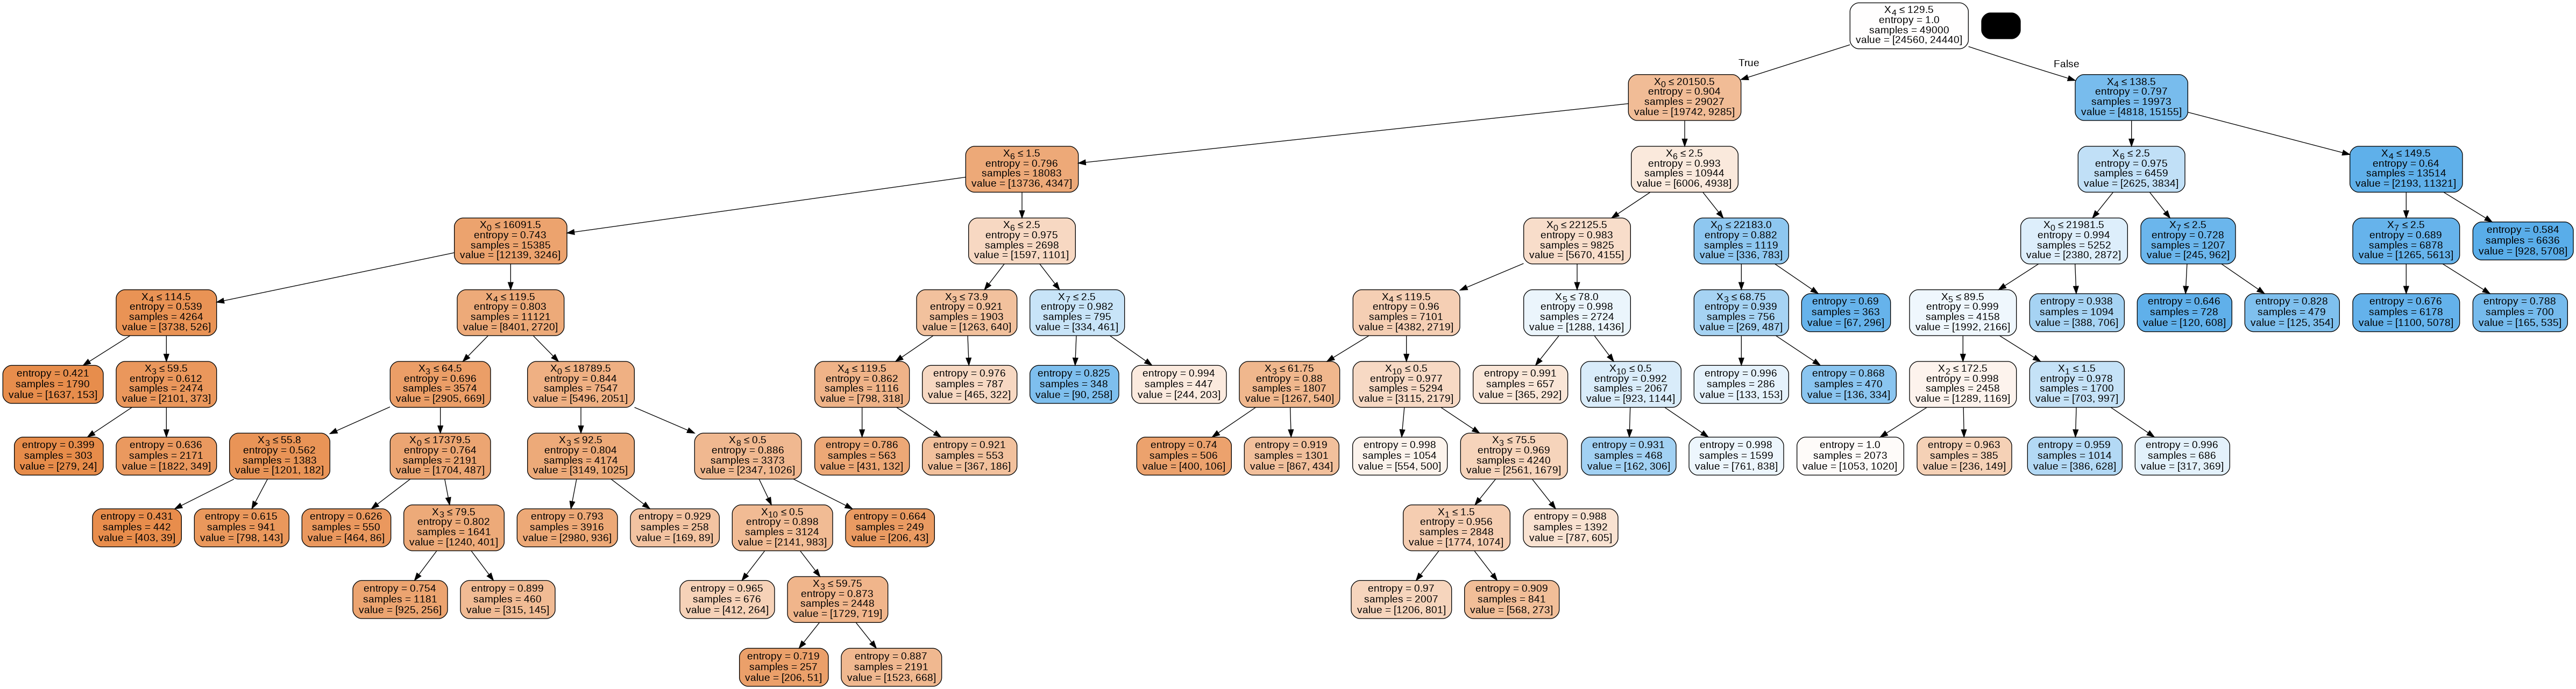

In [67]:
# only do in case of not deep tree!
dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<a id='Problem12'></a>
### Problem 12
[back to contents](#home)

Написать код, который для данной матрицы объект-признак и данного
вектора ответов возращает оптимальную тройку: (номер фичи, порог, значение критерия) с точки зрения критериев Джини/Энтропийного. Для этого,
реализуйте функции, шаблоны которых представлены ниже. Протестируйте
ваш код на наборе данных: [students.csv](https://drive.google.com/file/d/1bZMmnsJpDETdVtZQXFLu_gjhJZLPk2ey/view?usp=sharing) (целевая переменная: UNS).

In [71]:
data = pd.read_csv('/content/drive/MyDrive/Data/students.csv')
data.columns = [col.strip().lower() for col in data.columns]
print(f"{data.shape[0]:,} x {data.shape[1]:,}")
data.head()

258 x 6


,stg,scg,str,lpr,peg,uns
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [72]:
target = data['uns']
X = data.drop(['uns'], axis=1)

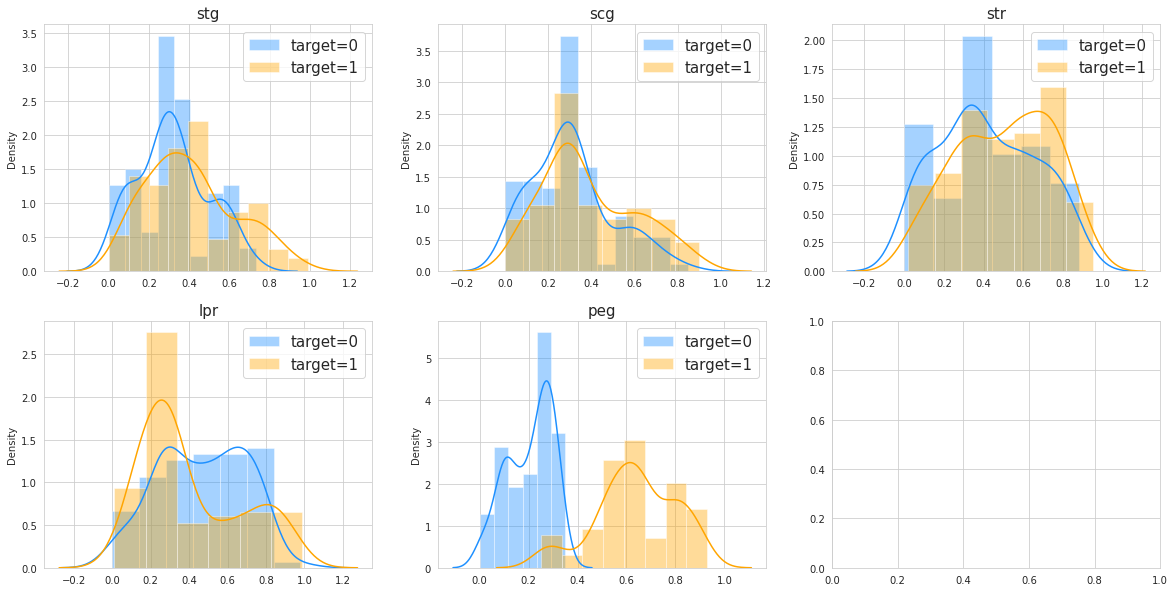

In [73]:
ncols=3
nrows = X.shape[1] // ncols if X.shape[1] % ncols == 0 else X.shape[1] // ncols + 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i, (row, col) in enumerate(itertools.product(range(nrows), range(ncols))):
  if i == X.shape[1]:
    break

  column = X.columns[i]
  ax[row, col].set_title(column, fontsize=15);
  sns.distplot(X[column][(target == 0)].values, color='dodgerblue', label='target=0', ax=ax[row, col])
  sns.distplot(X[column][(target == 1)].values, color='orange', label='target=1', ax=ax[row, col])
  ax[row, col].legend(fontsize=15);

In [74]:
import numpy as np

def compute_impurity(target_vector: np.ndarray, criterion: str='gini') -> float:

  """
  Computes impurity of particular leaf
  Args:
    target_vector: target vector for objects in this leaf
    criterion:
      entropy: sum(-p*log2p)
      gini: sum(p*(1-p))
  Returns:
    impurity (gini or entropy)
  """

  assert criterion in ['gini', 'entropy'], 'critetion could be "gini" or "entropy" as for now!'

  unq_classes, counts = np.unique(target_vector, return_counts=True)
  probas_vector = counts / counts.sum()

  if criterion == 'gini':
    return probas_vector @ (1 - probas_vector)
  elif criterion == 'entropy':
    return - probas_vector[probas_vector > 0] @ np.log2(probas_vector[probas_vector > 0])
  else:
    raise ValueError('critetion could be "gini" or "entropy" as for now!')


def compute_gain(target_vector: np.ndarray, feature_vector: np.ndarray, threshold: float, criterion: str='gini') -> float:

  """
  Computes gain of particular leaf split (H_R - |Rl|/|R| * H_Rl - |Rr|/|R| * H_Rr)
  """

  assert criterion in ['gini', 'entropy'], 'critetion could be "gini" or "entropy" as for now!'

  n = len(target_vector)
  n_left = sum(feature_vector < threshold)
  n_right = sum(feature_vector >= threshold)
  H_R = compute_impurity(target_vector=target_vector, criterion=criterion)
  H_Rl = compute_impurity(target_vector=target_vector[feature_vector < threshold], criterion=criterion)
  H_Rr = compute_impurity(target_vector=target_vector[feature_vector >= threshold], criterion=criterion)

  Q = H_R - (n_left/n)*H_Rl - (n_right/n)*H_Rr
  return Q

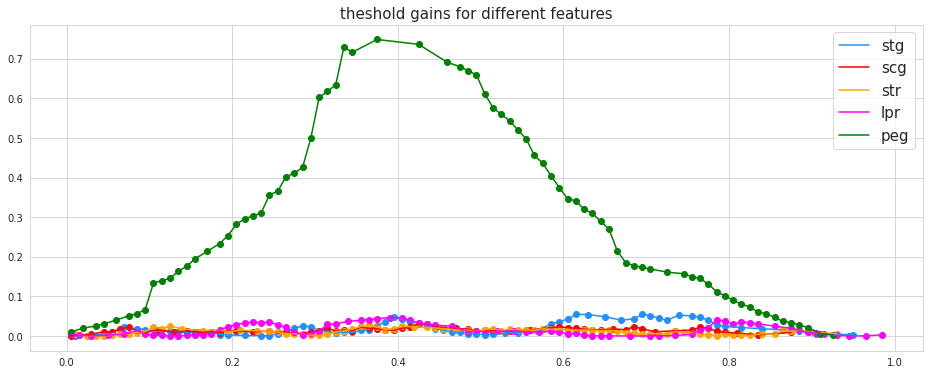

In [78]:
colors = np.array(['dodgerblue', 'red', 'orange', 'magenta', 'green', 'yellow', 'brown'])

plt.figure(figsize=(16, 6))
plt.title(f'theshold gains for different features', fontsize=15);
for i, col in enumerate(X.columns):
  unq_vals = np.sort(np.unique(X[col]))
  thresholds = (unq_vals[1:] + unq_vals[:-1]) / 2
  gain_vals = np.array([compute_gain(target_vector=target, feature_vector=X[col].values, threshold=t, criterion='entropy') for t in thresholds])  
  plt.plot(thresholds, gain_vals, color=colors[i], label=col)
  plt.scatter(thresholds, gain_vals, color=colors[i])  
plt.legend(fontsize=15);

<a id='Problem14'></a>
### Problem 14
[back to contents](#home)

Пусть имеется выборка $\{ (x_{i}, y_{i}) \}_{i=1}^{n}, \ x_{i},
 y_{i} \in \mathbb{R}$. Хотим найти коэффициенты $a, b, c$ такие, что Q минимально. Где\\

$$Q = \sum\limits_{i=1}^n \left( f(x_{i}) - y_{i} \right)^2$$

$$
f(x) = \left\{ \begin{array}{cc}
     a, \ x \le c  \\
     b, \ x > c 
\end{array}
\right .
$$

Для этого предлагается дополнить следующий код:

```python
import numpy as np
from numpy.typing import NDArray
from math import inf

class DecisionStump:
    def __init__(self):
        """
        f(x) = a*[x <= c] + b*[x > c]
        """
        self.a, self.b, self.c = None, None, None
        
    def fit(self, x: NDArray[float], y: NDArray[float]):
        pass

    def predict(self, x: NDArray[float]) -> NDArray[float]:
        pass
```

In [6]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([3, 3, 3, 3, 3, -2, -2, -2, -2, -2])
#a, b, c = 3, -2, 5.5 # c could be any in (5, 6)

# x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
# y = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, 5, 5, 5, 5])
#a, b, c = -1, 5, 10.5 # could be any in (10, 11)

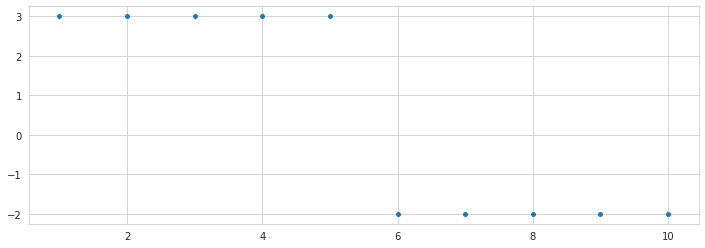

In [20]:
plt.figure(figsize=(12, 4))
plt.scatter(x, y, s=15);

In [15]:
import numpy as np
from numpy.typing import NDArray
from math import inf

def mse(y_true: NDArray[float], y_pred: NDArray[float]) -> float:
  return np.mean((y_true - y_pred)**2)

class DecisionStump:
    def __init__(self):
        """
        f(x) = a*[x <= c] + b*[x > c]
        """
        self.a, self.b, self.c = None, None, None

    def fit(self, x: NDArray[float], y: NDArray[float]):
        unq_vals = np.sort(np.unique(x))
        thresholds = (unq_vals[1:] + unq_vals[:-1]) / 2
        best_threshold, best_mse = None, None
        for threshold in thresholds:
          left_pred, right_pred = y[x < threshold].mean(), y[x >= threshold].mean()
          y_pred = left_pred * (x < threshold) + right_pred * (x >= threshold)
          curr_mse = mse(
                y_true=y,
                y_pred=y_pred
            )
          if best_mse is None:
            self.a = left_pred
            self.b = right_pred
            self.c = threshold
            best_mse = curr_mse
            best_threshold = threshold
          
          if curr_mse < best_mse:
            best_mse = curr_mse
            best_threshold = threshold
            self.a = left_pred
            self.b = right_pred
            self.c = threshold

        return self

    def predict(self, x: NDArray[float]) -> NDArray[float]:
        if self.a is None:
          raise ValueError('train you decision stump first!')

        return self.a * (x < self.c) + self.b * (x >= self.c)


In [21]:
dc = DecisionStump()
dc.fit(x, y)
print(dc.a, dc.b, dc.c)

3.0 -2.0 5.5


In [17]:
x_test = np.linspace(x.min(), x.max(), 100)
y_pred = dc.predict(x_test)

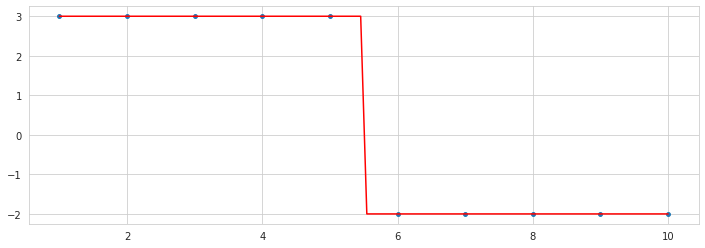

In [19]:
plt.figure(figsize=(12, 4))
plt.scatter(x, y, s=15)
plt.plot(x_test, y_pred, color='red');